### Structural Estimation Q1

Lets load some packages and import the data of health claim amounts.

In [2]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats as sts
import scipy.integrate as intgr
%matplotlib inline

In [3]:
clms = pd.read_csv("clms.txt", header = None, names = ["Hexp"])

#### (a)

We can print the summary statistics of the dataset.

In [4]:
mean = clms.mean()[0]
median = clms.median()[0]
std = clms.std()[0]
datamax = clms.max()[0]
datamin = clms.min()[0]
print("Mean of Data = ", mean, "\nMedian of Data = ", median, "\nStandard Deviation = ", std, "\nMaximum = ", datamax, "\nMinimum = ", datamin)

Mean of Data =  720.277975327 
Median of Data =  172.21 
Standard Deviation =  3972.85082412 
Maximum =  227967.25 
Minimum =  0.01


Here, we note that we have a maximum value significantly larger than the mean, which also corresponds to a large standard deviation. This might suggest an outlier in the data.

Next, we will plot two histograms of the data in which the y-axis is the percent of observations, and the x-axis is the value of monthly health expenditures. We vary the two histograms by the number of bins used to plot the data, as well as the range of the x axis.

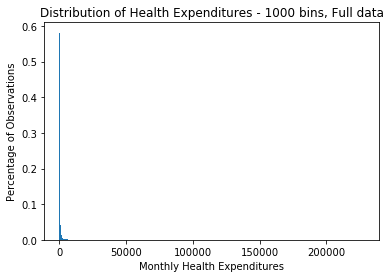

In [5]:
# We can plot the histogram with the inbuilt pandas function.
num_bins = 1000
weights = (1/clms.shape[0])*np.ones_like(clms['Hexp'])
n, bin_cuts, patches = plt.hist(clms['Hexp'], num_bins, weights = weights)
plt.title("Distribution of Health Expenditures - 1000 bins, Full data")
plt.xlabel("Monthly Health Expenditures")
plt.ylabel("Percentage of Observations")
plt.show()

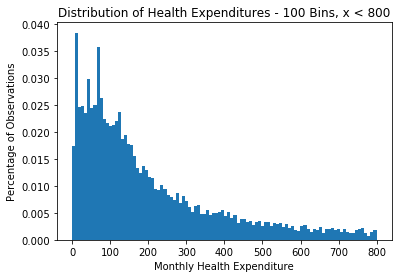

In [6]:
# Now lets try one with a bound on x.
num_bins2 = 100
forplot = clms[clms.Hexp < 800]['Hexp']
weights2 = (1/clms.shape[0])*np.ones_like(forplot)
n, bin_cuts, patches = plt.hist(forplot, num_bins2, weights = weights2)
plt.title("Distribution of Health Expenditures - 100 Bins, x < 800")
plt.xlabel("Monthly Health Expenditure")
plt.ylabel("Percentage of Observations")
plt.show()

We might perfer the second histogram as it shows the spread of the data much better than the first. This is probably due to the presence of large outliers in the data which causes the range of the first histogram to be overly large.

#### (b)

We use maximum likelihood to estimate the parameters $\alpha$ and $\beta$ for a gamma distribution with pdf
$$ f(x; \alpha, \beta) = \frac{1}{\beta^\alpha \Gamma(\alpha)} x^{\alpha - 1} e^{-x/\beta} $$

In [7]:
from scipy.special import gamma
import scipy.optimize as opt

# Code up pdf function, log_likehood function and criterion function for optimization.
def gammapdf(x ,a, b):
    return 1/((b**a)* gamma(a)) *(x ** (a - 1))* np.exp(-x/b)

def loglikgamma(xvals, a, b):
    pdf_vals = gammapdf(xvals, a, b)
    log_pdf_vals = np.log(pdf_vals)
    log_lik_gamma = np.sum(log_pdf_vals)
    return log_lik_gamma

def crit(params, xvals):
    a, b = params
    log_lik_val =  loglikgamma(xvals, a, b)
    neg_log_lik_val = - log_lik_val
    return neg_log_lik_val


Estimated Values for Alpha =  0.221751150097 
Estimated Values for Beta =  21913.1282774 
Maximized Log Lik =  -82076.64049652463


C:\Users\Kenneth\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in power
  


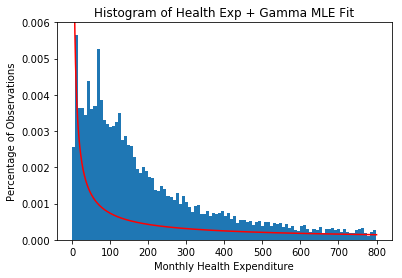

In [8]:
#Initializing guess and optimizing

b_init = std**2 / mean
a_init = mean / b_init
params_init = np.array([a_init, b_init])
xvals = (clms['Hexp'])

results = opt.minimize(crit, params_init, args = xvals, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))

gamma_mle_alpha = results.x[0]
gamma_mle_beta = results.x[1]

print("Estimated Values for Alpha = ", results.x[0], "\nEstimated Values for Beta = ", 
      results.x[1], "\nMaximized Log Lik = ", -results.fun)

# Plotting results
num_bins2 = 100
forplot = clms[clms.Hexp < 800]['Hexp']
weights2 = (1/clms.shape[0])*np.ones_like(forplot)
n, bin_cuts, patches = plt.hist(forplot, num_bins2, normed = True)

xgrid = np.linspace(0, 800, 1000)
plt.plot(xgrid, gammapdf(xgrid, results.x[0], results.x[1]), color='r')

plt.title("Histogram of Health Exp + Gamma MLE Fit")
plt.xlabel("Monthly Health Expenditure")
plt.ylabel("Percentage of Observations")
plt.ylim(0, 0.006)
plt.show()


#### (c)
Next, we use MLE to estimate parameters $\alpha$, $\beta$, $m$ for the generalized gamma distribution with pdf
$$ f(x; \alpha, \beta, m) = \frac{m / \beta^\alpha}{\Gamma(\alpha/m)} x^{\alpha - 1} e^{- (x/\beta)^m} $$

In [9]:
# Code up pdf function, log_likehood function and criterion function for optimization.
def gammagenpdf(x ,a, b,m):
    return (m/((b**a)*gamma(a/m)))*(x**(a-1))*(np.exp(-(x/b)**m))

def loglikgammagen(xvals, a, b,m):
    pdf_vals = gammagenpdf(xvals, a, b,m)
    log_pdf_vals = np.log(pdf_vals)
    log_lik_gamma = np.sum(log_pdf_vals)
    return log_lik_gamma

def crit2(params, xvals):
    a, b, m = params
    log_lik_val =  loglikgammagen(xvals, a, b,m)
    neg_log_lik_val = - log_lik_val
    return neg_log_lik_val


Estimated Values for Alpha =  

C:\Users\Kenneth\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in power
  This is separate from the ipykernel package so we can avoid doing imports until


0.221749655025 
Estimated Values for Beta =  21913.1280256 
Estimated Value for m =  0.997685861621 
Maximized Log Lik =  -82076.63530261679


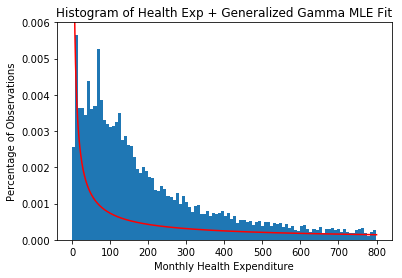

In [10]:
#Initializing guess and optimizing

b_init = gamma_mle_beta
a_init = gamma_mle_alpha
params_init = np.array([a_init, b_init, 1])
xvals = (clms['Hexp'])

results2 = opt.minimize(crit2, params_init, args = xvals, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None), (1e-10, None)))

gammagen_mle_alpha = results2.x[0]
gammagen_mle_beta = results2.x[1]
gammagen_mle_m = results2.x[2]

print("Estimated Values for Alpha = ", gammagen_mle_alpha, "\nEstimated Values for Beta = ", 
      gammagen_mle_beta, "\nEstimated Value for m = ", gammagen_mle_m, "\nMaximized Log Lik = ", -results2.fun)

# Plotting results
num_bins2 = 100
forplot = clms[clms.Hexp < 800]['Hexp']
weights2 = (1/clms.shape[0])*np.ones_like(forplot)
n, bin_cuts, patches = plt.hist(forplot, num_bins2, normed = True)

plt.plot(xgrid, gammagenpdf(xgrid, gammagen_mle_alpha, gammagen_mle_beta, gammagen_mle_m), color='r')

plt.title("Histogram of Health Exp + Generalized Gamma MLE Fit")
plt.xlabel("Monthly Health Expenditure")
plt.ylabel("Percentage of Observations")
plt.ylim(0, 0.006)
plt.show()


In this case, it appears that estimating the additional parameter does not change our distribution much since m is still close to 1

#### (d)

We will still use MLE to estimate the parameters (a, b, p, q) for the generalized beta 2 distribution with pdf:

$$ f(x;a,b,p,q) = \frac{|a| x^{ap -1} (1 -( x/b)^a)^{q-1}}{b^{ab} B(p,q)} $$

In [11]:
# Code up pdf function, log_likehood function and criterion function for optimization.
from scipy.special import beta
def gb2pdf(x ,a, b, p, q):
    return (a*(x**(a*p-1)))/(b**(a*p) * beta(p,q)*((1+(x/b)**a)**(p+q)))

def loglikegb2(xvals, a, b,p, q):
    pdf_vals = gb2pdf(xvals, a, b,p, q)
    log_pdf_vals = np.log(pdf_vals)
    log_lik_gamma = np.sum(log_pdf_vals)
    return log_lik_gamma

def crit3(params, xvals):
    a, b, p, q = params
    log_lik_val =  loglikegb2(xvals, a, b,p,q)
    neg_log_lik_val = - log_lik_val
    return neg_log_lik_val


Estimated Values for a =  0.699555419032 
Estimated Values for b =  223863041.624 
Estimated Value for p =  0.994292546265 
Estimated Values for q =  9997.79016852 
Maximized Log Lik =  -76461.49134700361


C:\Users\Kenneth\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


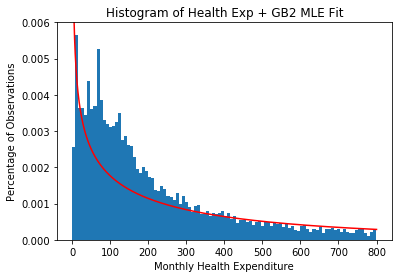

In [12]:
#Initializing guess and optimizing

b_init = 10000**(1/gammagen_mle_m)*gammagen_mle_beta
a_init = gammagen_mle_m
q_init = 10000
p_init = gammagen_mle_alpha / gammagen_mle_m

params_init = np.array([a_init, b_init, p_init, q_init])
xvals = (clms['Hexp'])

results2 = opt.minimize(crit3, params_init, args = xvals, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None), (1e-10, None),(1e-10, None)))

gb2_mle_a = results2.x[0]
gb2_mle_b = results2.x[1]
gb2_mle_p = results2.x[2]
gb2_mle_q = results2.x[3]

print("Estimated Values for a = ", gb2_mle_a, "\nEstimated Values for b = ", 
      gb2_mle_b, "\nEstimated Value for p = ", gb2_mle_p, "\nEstimated Values for q = ", gb2_mle_q,
      "\nMaximized Log Lik = ", -results2.fun)

# Plotting results
num_bins2 = 100
forplot = clms[clms.Hexp < 800]['Hexp']
weights2 = (1/clms.shape[0])*np.ones_like(forplot)
n, bin_cuts, patches = plt.hist(forplot, num_bins2, normed = True)

plt.plot(xgrid, gb2pdf(xgrid, gb2_mle_a, gb2_mle_b, gb2_mle_p, gb2_mle_q), color='r')

plt.title("Histogram of Health Exp + GB2 MLE Fit")
plt.xlabel("Monthly Health Expenditure")
plt.ylabel("Percentage of Observations")
plt.ylim(0, 0.006)
plt.show()


#### (e)

We can construct the likelihood ratio test for each of the MLE estimators in (b), (c) with the one in (d) since they are nested cases of (d).

$$ L(\theta_{(b)/(c)} | \theta_{(d)}) = 2*(\log L(\theta_{(d)} - \log L(\theta_{(b)/(c)}) \sim \chi^2(4)$$

In [14]:
log_like_mlegamma = loglikgamma(xvals, gamma_mle_alpha, gamma_mle_beta)
log_like_gammagen = loglikgammagen(xvals, gammagen_mle_alpha, gammagen_mle_beta, gammagen_mle_m)
log_like_gb2 = loglikegb2(xvals, gb2_mle_a, gb2_mle_b, gb2_mle_p, gb2_mle_q)

LR_val_bd = 2 * (log_like_gb2 - log_like_mlegamma)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val_bd, 4)
LR_val_cd = 2 * (log_like_gb2 - log_like_gammagen)
pval_h1 = 1.0 - sts.chi2.cdf(LR_val_cd, 4)
print('P-value of chi-squared test for estimates of GA = ', pval_h0)
print('P-value of chi-squared test for estimates of GG = ', pval_h1)

P-value of chi-squared test for estimates of GA =  0.0
P-value of chi-squared test for estimates of GG =  0.0


In this case, the p-value is extremely small, implying that we can reject the null hypothesis that our true distribution is distributed by the generalized gamma or the gamma distribution. This suggests that the GB2 distribution used would be the prefered distribution in matching the data.

#### (f)

In [211]:
# To compute this, we can perform numerical integration

prob_GB2_1000 = intgr.quad(gb2pdf,1000,1e6 ,args = (gb2_mle_a, gb2_mle_b, gb2_mle_p, gb2_mle_q))[0]
prob_GA_1000 = intgr.quad(gammapdf, 1000, 1e6, args = (gamma_mle_alpha, gamma_mle_beta))[0]

print("Probability of Healthcare Exp > 1000 under GB2 = ", prob_GB2_1000)
print("Probability of Healthcare Exp > 1000 Under GA = ", prob_GA_1000)

Probability of Healthcare Exp > 1000 under GB2 =  0.1624857873701475
Probability of Healthcare Exp > 1000 Under GA =  0.4519642389977817


It appears that the probability of spending more than 1000 under the GB2 distribution is significantly smaller than that under the gamma distribution.